# Visualise un-delayed demand for beds for admitted patients

One reason why Emergency Departments (EDs) fail to meet admissions targets is because beds are not available at the time patients arrive. Most discharges happen in the afternoon, so patients arriving at night into a full hospital often have to wait until late the following day to be admitted. UCLH wanted to understand their un-delayed demand over the course of a day - that is, when beds would be needed if patients were processed within the 4-hour target time. A formal term for this (used in queueing theory) is "offered load". Here we use "un-delayed demand" as it better conveys the concept to healthcare staff. UCLH wanted to understand their undelayed demand patterns to inform an improvement project focus on their emergency patient pathway.

This notebook generates charts that aim to answer the following questions: 

* What is the typical pattern of arrivals of admitted patients over the day?
* If ED was meeting 4-hour targets for admitted patients, when would beds for these patients need to be ready?**
* Are there differences in the above between weekends and weekdays? 
* The discharge window, when decision-makers are on wards, is between 8.30 am and 5 pm. If a hospital wants to meet its ED targets on a consistent basis, then there should be enough empty beds to cover demand over night by the end of the discharge window when decision-makers leave. How many beds would need to be available at the end of discharge window to cover all demand over night? 

To answer these questions we will prepare a model using only 

* historical arrival rates of patients later admitted
* 4-hour targets for ED. We assume that the hospital might want to choose a certain percentage of admitted patients to be processed into a bed within 4 hours, accordingly to current targets. 

Here we refer to both Emergency Department (EDs) and Same Day Emergency Care (SDECs) since patients can be admitted to the hospital from both. 




## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()

Inferred project root: /home/jovyan/work/patientflow


## Set file paths

In [56]:
from patientflow.load import set_file_paths
from patientflow.load import load_config_file

# set file locations
data_folder_name = 'data-raw-undelayed-demand' 

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(project_root, 
               data_folder_name=data_folder_name, config_file='config-uclh.yaml')

# create subfolders for weekdays and weekends
media_file_path_weekdays = media_file_path / 'undelayed-demand-uclh' / 'weekdays'
media_file_path_weekends = media_file_path / 'undelayed-demand-uclh' / 'weekends'
media_file_path_all_days = media_file_path / 'undelayed-demand-uclh' / 'all_days'

    
media_file_path_weekdays.mkdir(parents=True, exist_ok=True)
media_file_path_weekends.mkdir(parents=True, exist_ok=True)
media_file_path_all_days.mkdir(parents=True, exist_ok=True)

Configuration will be loaded from: /home/jovyan/work/patientflow/config-uclh.yaml
Data files will be loaded from: /home/jovyan/work/patientflow/data-raw-undelayed-demand
Trained models will be saved to: /home/jovyan/work/patientflow/trained-models/raw-undelayed-demand
Images will be saved to: /home/jovyan/work/patientflow/trained-models/raw-undelayed-demand/media


## Load parameters

These are set in config.json. 

In [4]:
# load params from config file
params = load_config_file(config_path)

# prediction_times = params["prediction_times"]
# start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
# prediction_window = params["prediction_window"]
# epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]

print(f'The aspiration is for {y1*100}% of patients to be admitted within {x1} hours, and {y2*100}% of patients to be admitted within {x2} hours')

The aspiration is for 78.0% of patients to be admitted within 4.0 hours, and 99.0% of patients to be admitted within 12.0 hours


## Load data

Here we load the data. NOTE - the public data is a subset of UCLH arrivals, so the charts here will underestimate the demand at UCLH. 

In [13]:
data_file_path
inpatient_arrivals = load_data(data_file_path, 
                    file_name='ed_sdec_ct_3.csv')
inpatient_arrivals

/home/jovyan/work/patientflow/src/patientflow/load.py:491: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=True)


,HospitalProviderSpellNumber,AdmissionType,is_child,Sex,arrival_datetime,arrival_day,IsED_Flag,IsSDEC_Flag,IsEDAndSDEC_Flag,SDEC_In_Datetime,Ward_In_Datetime,SiteCode,WardCode,DestinationPatientService,RequestedInstant,SourceWard,DestWard
0,1010666217,"Emergency Admission - A&E, Casualty, or Dental...",False,M,31/03/2019 03:49,Sunday,1,0,0,NaN,31/03/2019 11:24,UCHC,UCH T01 AMU,Acute Medicine,24:47.0,UCH ED,UCH T01 AMU
1,1010666447,*Unspecified,False,F,31/03/2019 03:57,Sunday,1,0,0,NaN,31/03/2019 06:55,UCHC,UCH T01 AMU,Acute Medicine,21:37.0,UCH ED,UCH T01 AMU
2,1010666448,"Emergency Admission - A&E, Casualty, or Dental...",False,F,31/03/2019 04:06,Sunday,1,0,0,NaN,31/03/2019 16:25,UCHC,UCH T00 EAU,Acute Medicine,55:59.0,UCH ED,UCH T00 EAU
3,1010666462,"Emergency Admission - A&E, Casualty, or Dental...",False,M,31/03/2019 04:41,Sunday,1,0,0,NaN,31/03/2019 10:52,UCHC,UCH T09S,Accident & Emergency,48:08.0,UCH ED,UCH T09S
4,1010666470,"Emergency Admission - A&E, Casualty, or Dental...",False,F,31/03/2019 04:48,Sunday,1,0,0,NaN,31/03/2019 08:36,UCHC,UCH T01 AMU,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106937,1060761272,"Emergency Admission - A&E, Casualty, or Dental...",False,F,12/03/2025 17:00,Wednesday,1,0,0,NaN,12/03/2025 21:26,UCHC,UCH T14S ASU,General Surgery - General,31:14.0,UCH ED,UCH T14S ASU
106938,1060760893,"Emergency Admission - A&E, Casualty, or Dental...",False,M,12/03/2025 17:18,Wednesday,1,0,0,NaN,12/03/2025 22:09,UCHC,UCH T14S ASU,Oncology - Head and Neck - Medical,00:57.0,UCH ED,UCH T14S ASU
106939,1060762231,"Emergency Admission - A&E, Casualty, or Dental...",True,F,12/03/2025 17:22,Wednesday,1,0,0,NaN,12/03/2025 23:54,UCHC,UCH T12S,Paediatric - General,22:58.0,UCH ED,UCH T12S
106940,1060762573,"Emergency Admission - A&E, Casualty, or Dental...",False,F,12/03/2025 17:45,Wednesday,1,0,0,NaN,12/03/2025 18:22,UCHC,EGA MFAU,NaN,NaN,NaN,NaN


In [14]:
inpatient_arrivals.arrival_datetime.head()

0    31/03/2019 03:49
1    31/03/2019 03:57
2    31/03/2019 04:06
3    31/03/2019 04:41
4    31/03/2019 04:48
Name: arrival_datetime, dtype: object

In [15]:
import pandas as pd
import numpy as np
from patientflow.load import load_data

# load data
inpatient_arrivals = load_data(data_file_path, 
                    file_name='ed_sdec_ct_3.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)
inpatient_arrivals.set_index('arrival_datetime', inplace=True)

# select only data from 2023 onwards
inpatient_arrivals = inpatient_arrivals[inpatient_arrivals.index > '2023-01-01']


weekdays = inpatient_arrivals[(inpatient_arrivals.index.weekday < 5) & (inpatient_arrivals.index > '2023-01-01')]
weekends = inpatient_arrivals[(inpatient_arrivals.index.weekday >= 5) & (inpatient_arrivals.index > '2023-01-01')]



/home/jovyan/work/patientflow/src/patientflow/load.py:491: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=True)
/tmp/ipykernel_5301/4150430408.py:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)


In [16]:
# summarise
print(f"Weekday dates span {weekdays.index.date.min()} to {weekdays.index.date.max()}")
print(f"Weekend dates span {weekends.index.date.min()} to {weekends.index.date.max()}")



Weekday dates span 2023-01-02 to 2025-03-12
Weekend dates span 2023-01-01 to 2025-03-09


Note how simple the dataset is that is used in the rest of this notebook. The only columns used are the arrival_datetime index, and (at the very end of the notebook) the specialty of admission. Similar breakdown as for specialty could be done for by sex or for adults/children, if useful.

In [7]:
inpatient_arrivals.dtypes

training_validation_test    object
sex                         object
specialty                   object
is_child                      bool
dtype: object

## Get arrival rates by hour


### Calculate the arrival rates for each hour of the day, at weekdays and weekends, using the historical data

In [17]:
print(f"On average, there were {inpatient_arrivals[(inpatient_arrivals.index > '2023-01-01')].resample('D').size().mean():.3f} inpatients admitted per day")

On average, there were 47.651 inpatients admitted per day


In [18]:
from patientflow.calculate import time_varying_arrival_rates

arrival_rates_by_time_interval = time_varying_arrival_rates(
    df=inpatient_arrivals[(inpatient_arrivals.index > '2023-01-01')],
    yta_time_interval=yta_time_interval,
    verbose=True,
)

Inferring number of days from dataset
Calculating time-varying arrival rates for data provided, which spans 802 unique dates


The dictionary returned by this function breaks out the arrival rates into intervals defined by yta_time_interval

In [19]:
arrival_rates_by_time_interval

OrderedDict([(datetime.time(0, 0), 0.33790523690773067),
             (datetime.time(0, 15), 0.327930174563591),
             (datetime.time(0, 30), 0.30174563591022446),
             (datetime.time(0, 45), 0.2955112219451372),
             (datetime.time(1, 0), 0.29177057356608477),
             (datetime.time(1, 15), 0.29052369077306733),
             (datetime.time(1, 30), 0.2967581047381546),
             (datetime.time(1, 45), 0.22194513715710723),
             (datetime.time(2, 0), 0.21321695760598502),
             (datetime.time(2, 15), 0.2144638403990025),
             (datetime.time(2, 30), 0.16708229426433915),
             (datetime.time(2, 45), 0.17331670822942644),
             (datetime.time(3, 0), 0.1882793017456359),
             (datetime.time(3, 15), 0.18079800498753118),
             (datetime.time(3, 30), 0.17581047381546136),
             (datetime.time(3, 45), 0.15586034912718205),
             (datetime.time(4, 0), 0.16084788029925187),
             (datetime.ti

Below, confirming that the sum of these intervals equates to the same value

In [11]:
sum(arrival_rates_by_time_interval.values())

41.42156862745098

To get the correct demominator when calculating average arrival rates per weekday and weekend, we need to calculate the number of weekdays or weekends, and pass this into the function. Assuming that there was at least one inpatient per day, we can do this by counting the number of days in each dataset

In [20]:
num_weekdays = len(np.unique(weekdays.index.date))
num_weekends = len(np.unique(weekends.index.date))

print(f"On average, there were {len(weekdays)/num_weekdays:.1f} inpatients admitted per day over the {num_weekdays} weekdays included")
print(f"On average, there were {len(weekends)/num_weekends:.1f} inpatients admitted per day over the {num_weekends} weekend days included")

On average, there were 50.6 inpatients admitted per day over the 573 weekdays included
On average, there were 40.4 inpatients admitted per day over the 229 weekend days included


### Plot the arrival rates for each hour of the day, at weekdays and weekends, using the historical data

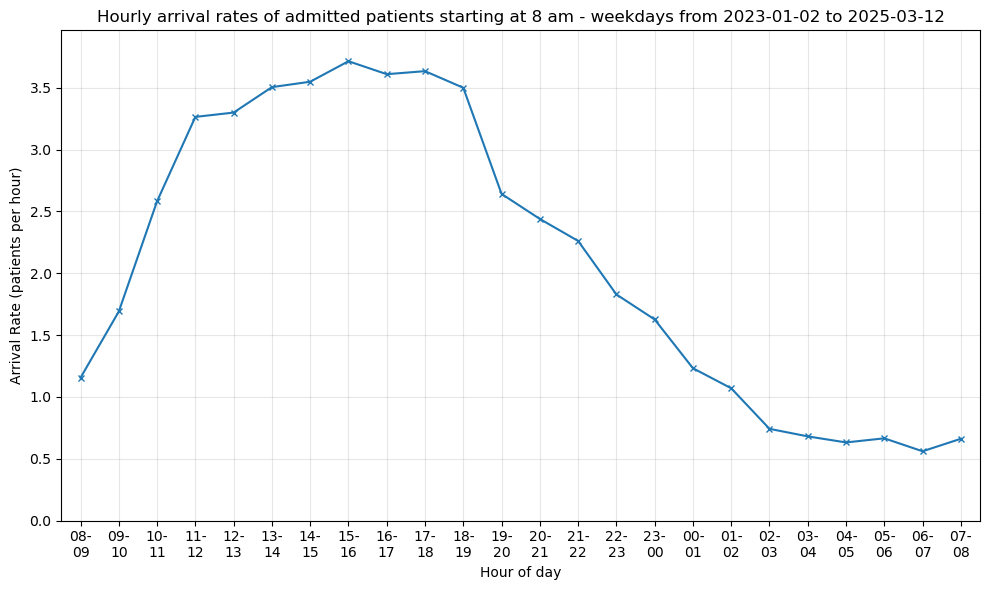

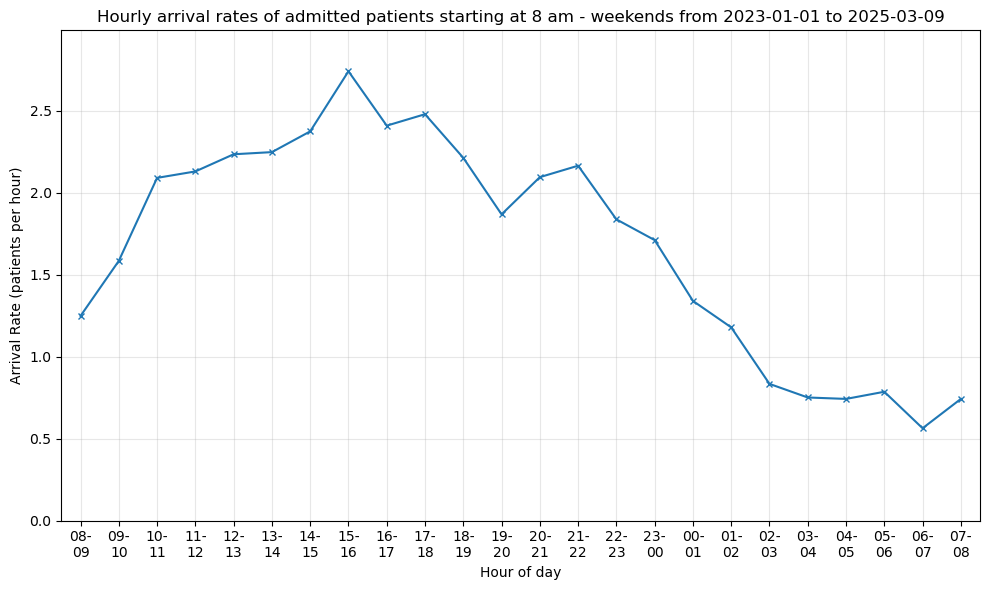

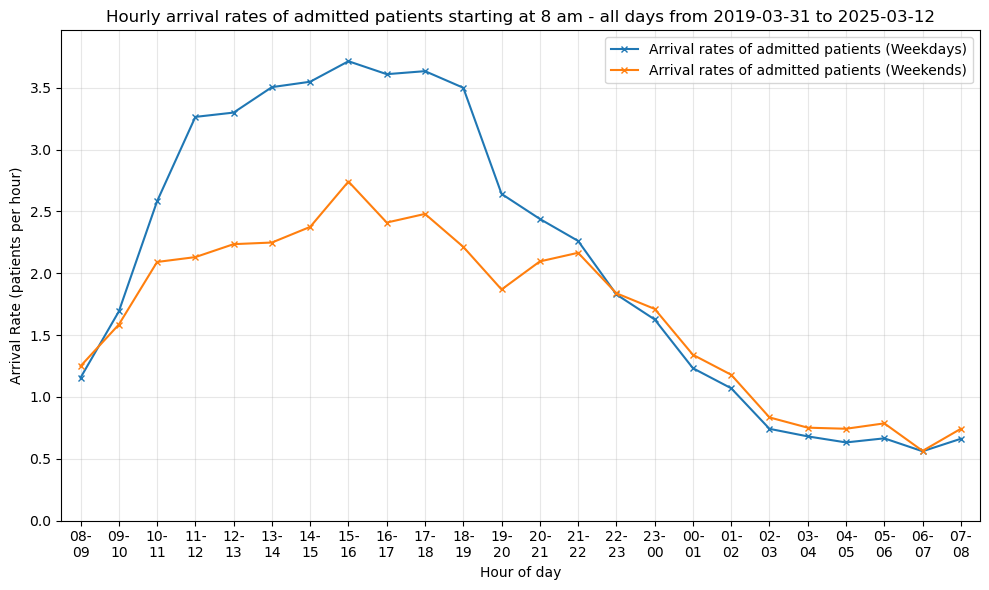

In [21]:
from patientflow.viz.arrival_rates import plot_arrival_rates
from datetime import timedelta

# Set the plot to start at the 8th hour of the day (if not set the function will default to starting at midnight
start_plot_index = 8

# plot for weekdays
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am - weekdays from {weekdays.index.date.min()} to {weekdays.index.date.max()}'
plot_arrival_rates(weekdays, 
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '1_',
                   media_file_path=media_file_path_weekdays,
                  num_days=num_weekdays)

# plot for weekends
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am - weekends from {weekends.index.date.min()} to {weekends.index.date.max()}'
plot_arrival_rates(weekends, 
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '1_',
                   media_file_path=media_file_path_weekends,
                  num_days=num_weekends
                   )


# plot for both
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am - all days from {inpatient_arrivals.index.date.min()} to {inpatient_arrivals.index.date.max()}'
plot_arrival_rates(inpatient_arrivals=weekdays,
                        inpatient_arrivals_2=weekends, 
                    labels=('Weekdays', 'Weekends'),
                   title=title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '1_',
                   media_file_path=media_file_path_all_days,
                   num_days=num_weekdays,
                   num_days_2=num_weekends
                   )

## Plot the time beds would be needed if each patient were admitted exactly 4 hours after arrival

We now make the assumption that the bed is needed exactly 4 hours after arrival. This assumes that every patient meets the 4-hour target, and that there is no variation in the time it takes people to be processed through ED/SDEC, so it is not realistic, but serves as a starting point. 

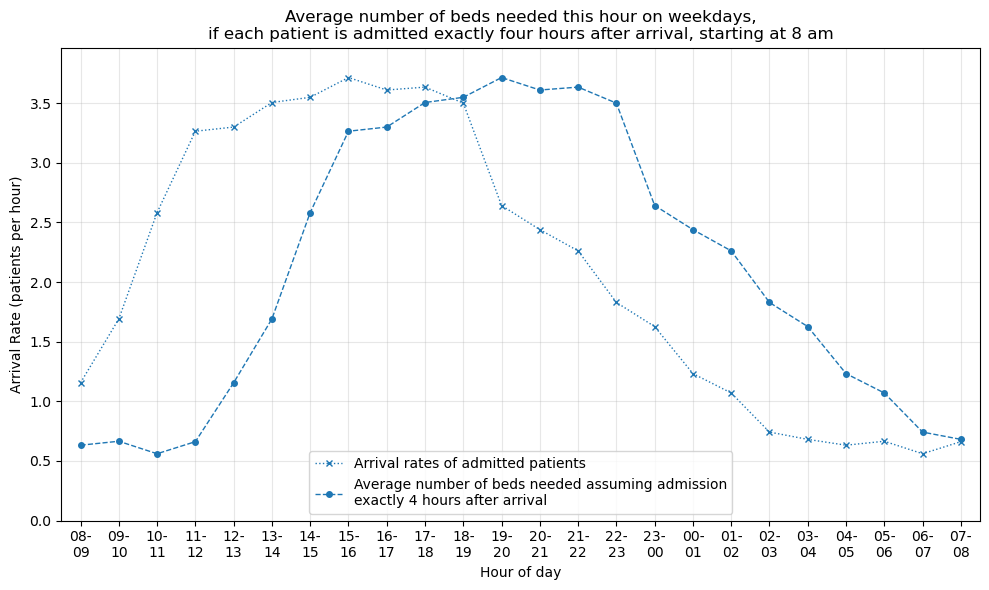

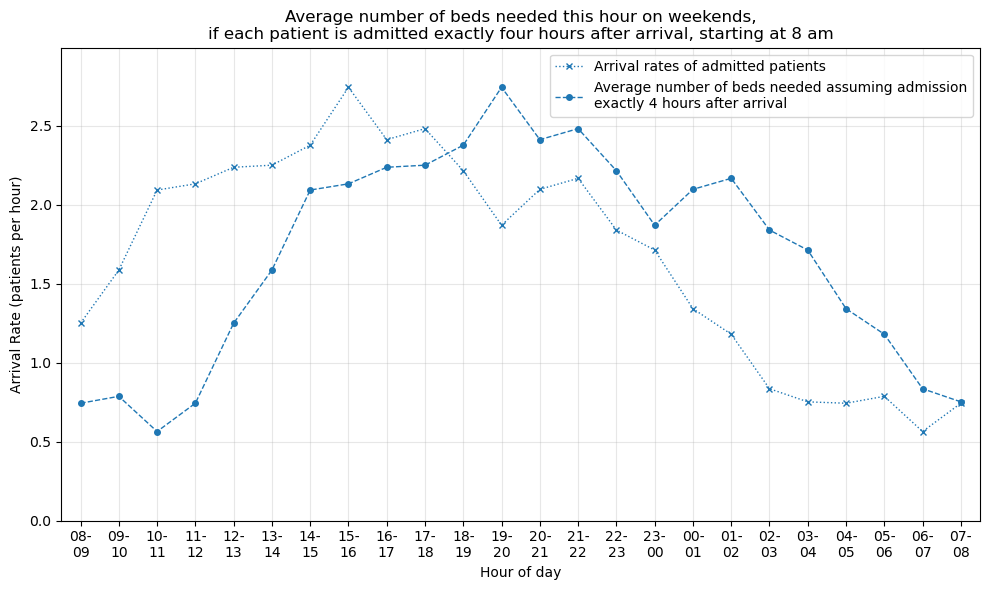

In [22]:
title = 'Average number of beds needed this hour on weekdays,\nif each patient is admitted exactly four hours after arrival, starting at 8 am'
plot_arrival_rates(weekdays,
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '2_', 
                   lagged_by=4,
                    media_file_path=media_file_path_weekdays,
                   num_days=num_weekdays,
)

title = 'Average number of beds needed this hour on weekends,\nif each patient is admitted exactly four hours after arrival, starting at 8 am'
plot_arrival_rates(weekends,
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '2_', 
                   lagged_by=4,
                    media_file_path=media_file_path_weekends,
                   num_days=num_weekends,
)

## Plot cumulative arrival rates

We can show the same information as above, counting the beds needed cumulatively over the day.   

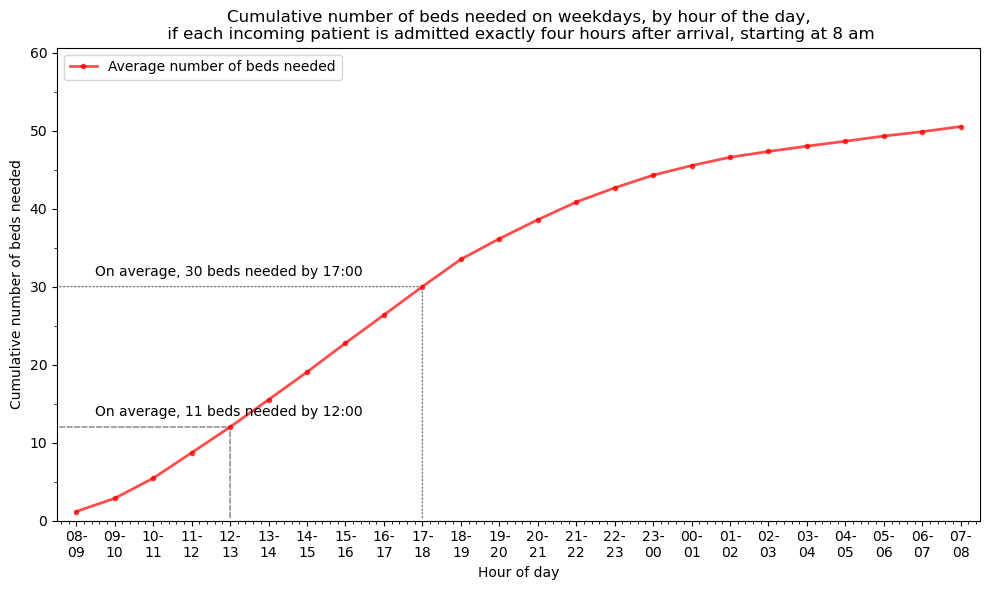

In [23]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates
title = f'Cumulative number of beds needed on weekdays, by hour of the day,\n if each incoming patient is admitted exactly four hours after arrival, starting at 8 am'
plot_cumulative_arrival_rates(
    weekdays,
    title,
    start_plot_index=8,
    media_file_path=media_file_path_weekdays,
    file_prefix='3_',
    num_days=num_weekdays
)

## Now considering the discharge window

Here we are interested in bringing forward the number of beds vacated at each hour, such that the necessary number of beds are vacated within the influenceable window before decision-makers leave the wards

We first define a dictionary of scenarios we'd like to plot. (This is simply to reduce lines of code.)

In [48]:
scenarios = {
    'weekdays' : {
            'data': weekdays,
            'file_path': media_file_path_weekdays,
            'label': 'weekdays',
            'num_days': num_weekdays
        },
    'weekends' : {
        'data': weekends,
        'file_path': media_file_path_weekends,
        'label': 'weekends',
        'num_days': num_weekends,        
    }
}



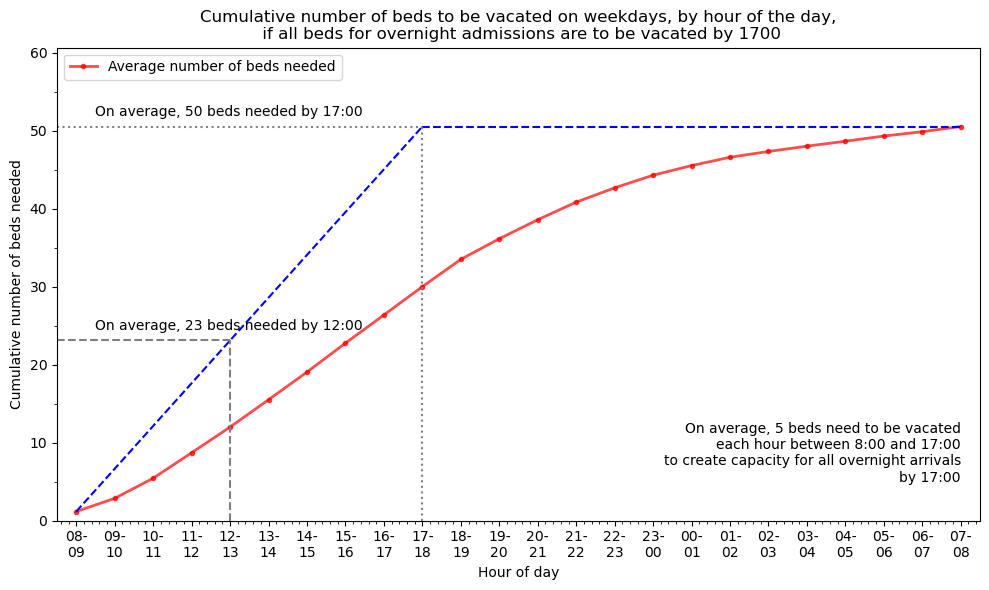

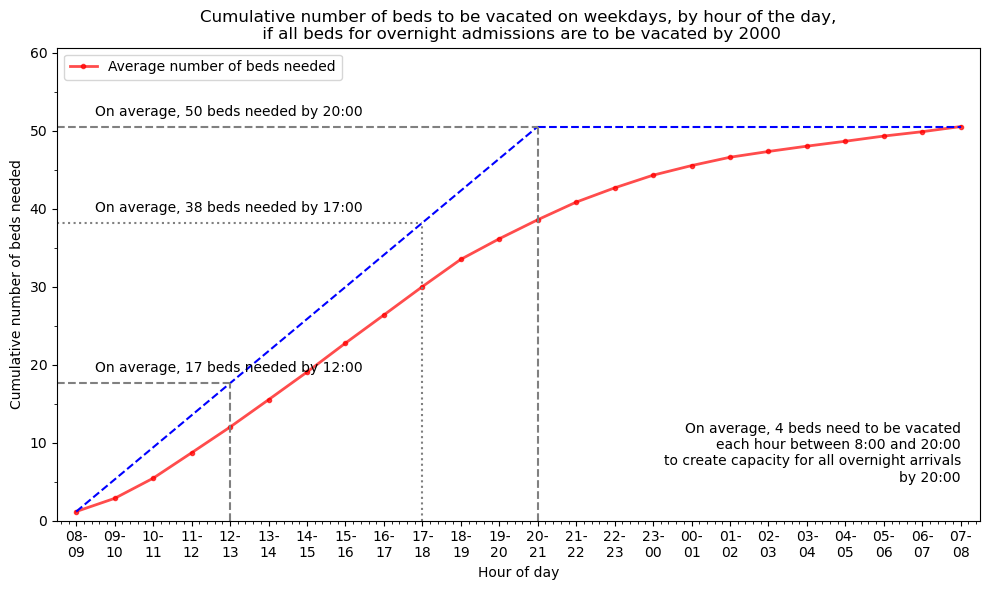

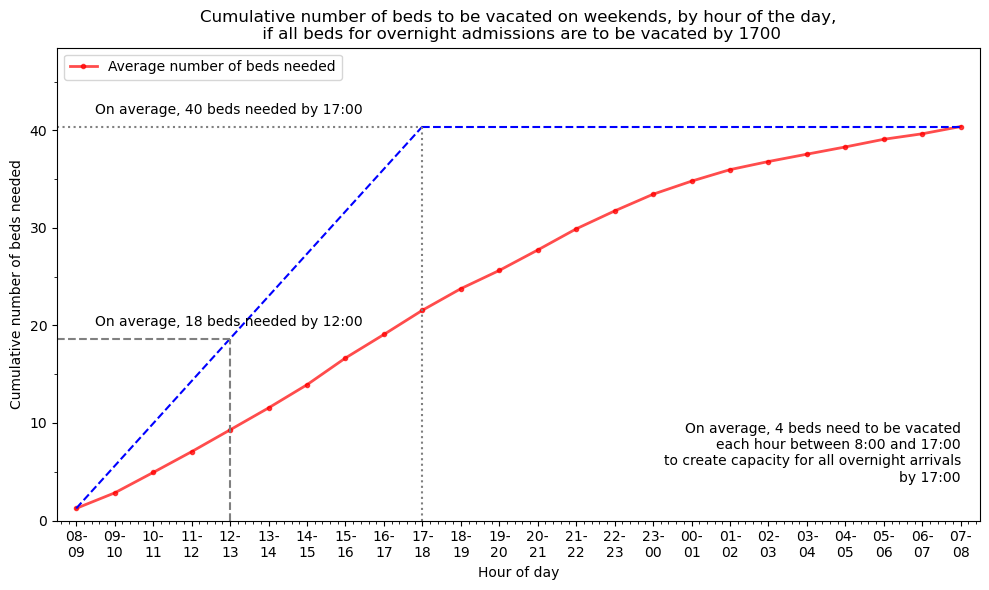

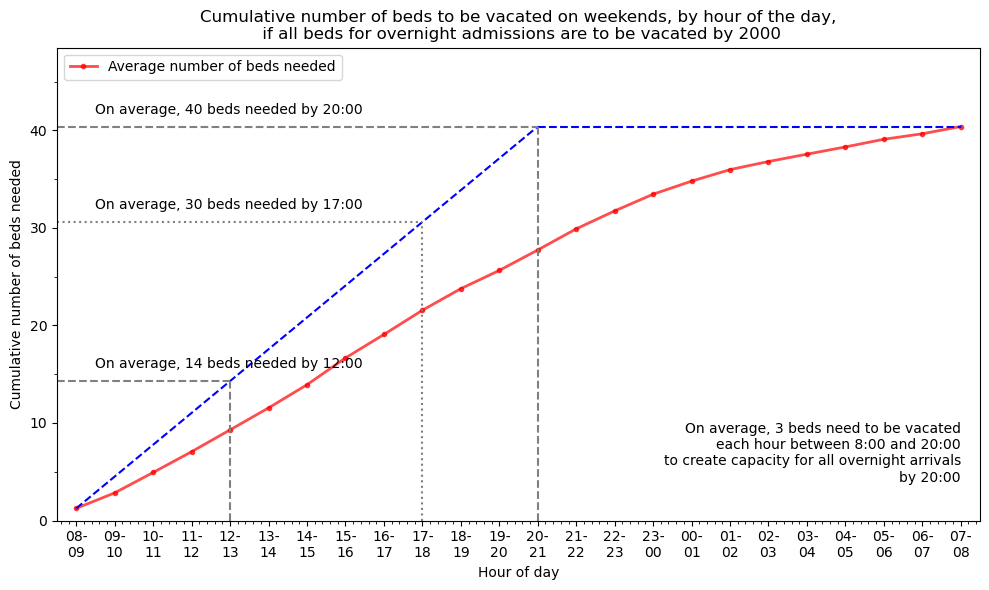

In [57]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates

start_of_influencable_window = 8
end_of_influencable_window = 17


def plot_average_beds_needed(scenarios):
    """
    Generate bed occupancy plots for both weekday and weekend data.
    """
    
    for key, scenario in scenarios.items():
        # First plot: 17:00 end of influencable window
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day,\n if all beds for overnight admissions are to be vacated by {17}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 17),
            media_file_path=scenario["file_path"],
            file_prefix='4_',
            # set_y_lim=55,
            num_days=scenario["num_days"]
        )
        
        # Second plot: 20:00 end of influencable window
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day,\n if all beds for overnight admissions are to be vacated by {20}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 20),
            media_file_path=scenario["file_path"],
            file_prefix='4_',
            # set_y_lim=55,
            hour_lines=[12,17,20],
            num_days=scenario["num_days"]
        )


plot_average_beds_needed(
    scenarios,
)


## Introducing an aspirational approach

As noted above, this is not very realistic as it assumes that every patient meets the 4-hour target, and that there is no variation in the time it takes people to be processed through ED/SDEC. Ideally patients would be processed sooner than 4 hours in most cases. 

We can instead use a probabilistic approach to determine whether any patient will be admitted within 4 hours. The probability is shown in the plot below.

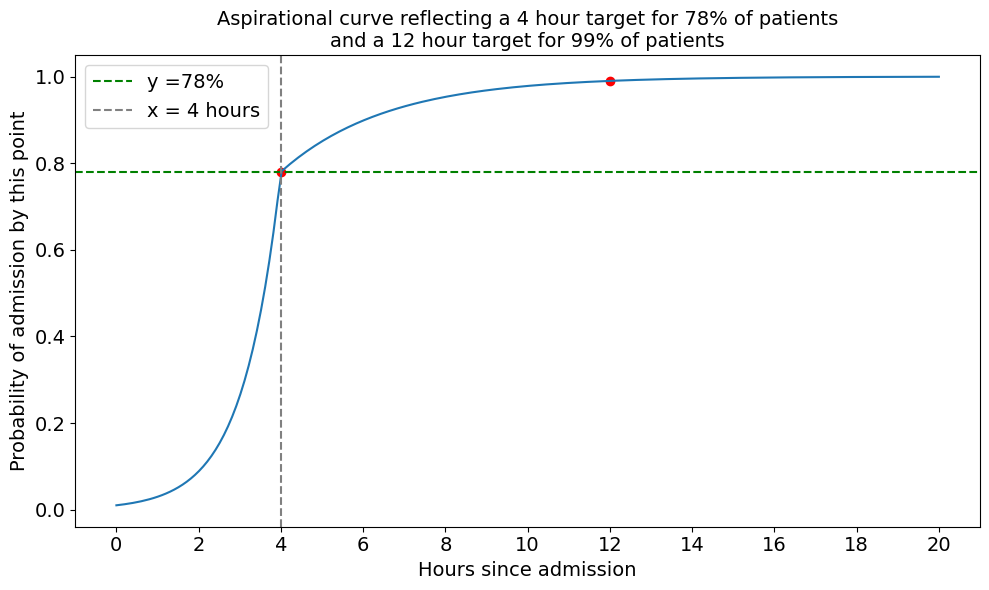

In [26]:
import matplotlib.pyplot as plt
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)
title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients'

plot_curve(
    title = title,
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    figsize = (10,6),
    include_titles=True,
    text_size=14,
    media_file_path=media_file_path_weekends,
    file_name=title.replace(" ", "_"),
)


## Plot the time beds would be needed after applying the aspirational curve

Here, the aspirational curve has been applied. It has the effect of smoothing out the times at which beds are needed (the solid line falls between the time people arrived and the line that is lagged by 4 hours)

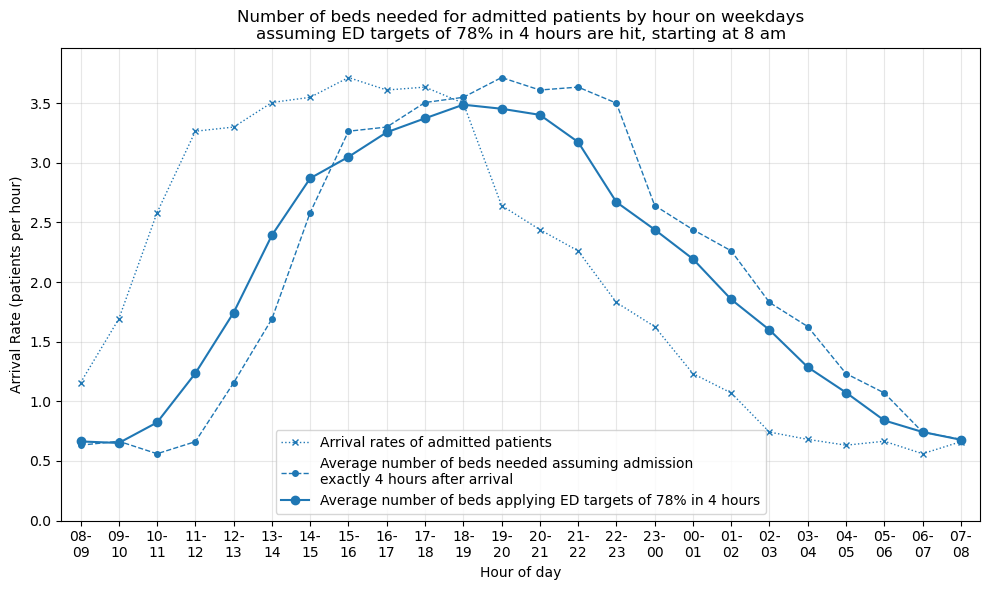

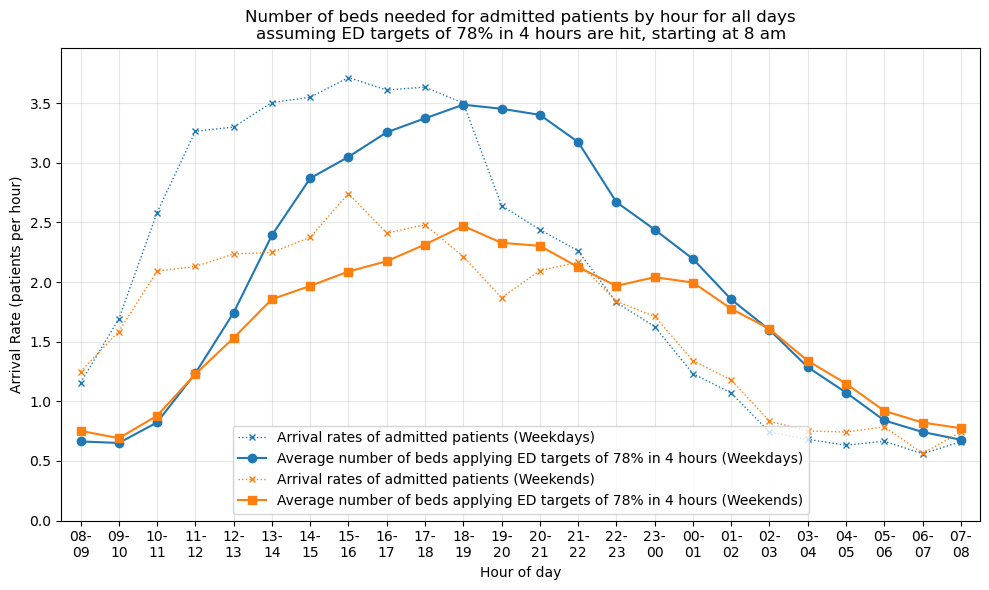

In [27]:

title = f'Number of beds needed for admitted patients by hour on weekdays\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'
plot_arrival_rates(weekdays, title, start_plot_index = 8, 
                   lagged_by=4, 
                   curve_params=(x1, y1, x2, y2), 
                   file_prefix = '5_',
                   media_file_path=media_file_path_weekdays,
                  num_days=num_weekdays)


# title = f'Number of beds needed for admitted patients by hour on weekends\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'
# plot_arrival_rates(weekends, title, start_plot_index = 8, 
#                    lagged_by=4, 
#                    curve_params=(x1, y1, x2, y2), 
#                    file_prefix = '5_',
#                     media_file_path=media_file_path_weekends,
                  # num_days=num_weekends)



# plot for both
title = f'Number of beds needed for admitted patients by hour for all days\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'
plot_arrival_rates(inpatient_arrivals=weekdays,
                        inpatient_arrivals_2=weekends, 
                    labels=('Weekdays', 'Weekends'),
                   title=title, 
                   # lagged_by=4, 
                   curve_params=(x1, y1, x2, y2), 
                    start_plot_index=start_plot_index, 
                   file_prefix = '5_',
                   media_file_path=media_file_path_weekends,
                  num_days=num_weekdays,
                   num_days_2=num_weekends
                   )

We can then plot the cumulative numbers required, applying the aspirational window as before

In [66]:
scenario = scenarios['weekdays']
str(scenario["label"])
title = f'Cumulative number of beds needed on {scenario["label"]}, by hour of the day,\n after applying aspirational ED performance curve, starting at 8 am'
title

'Cumulative number of beds needed on weekdays, by hour of the day,\n after applying aspirational ED performance curve, starting at 8 am'

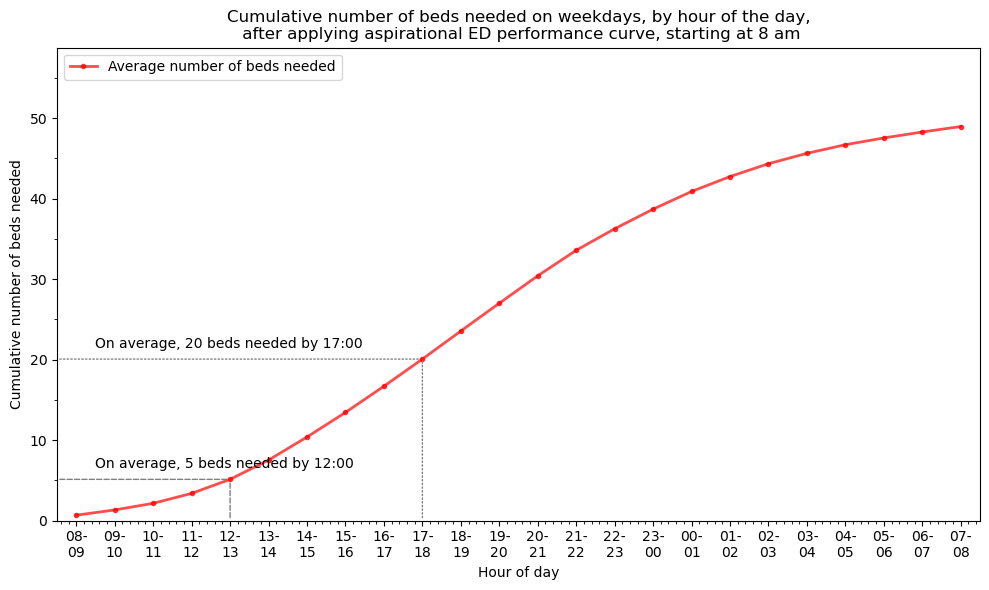

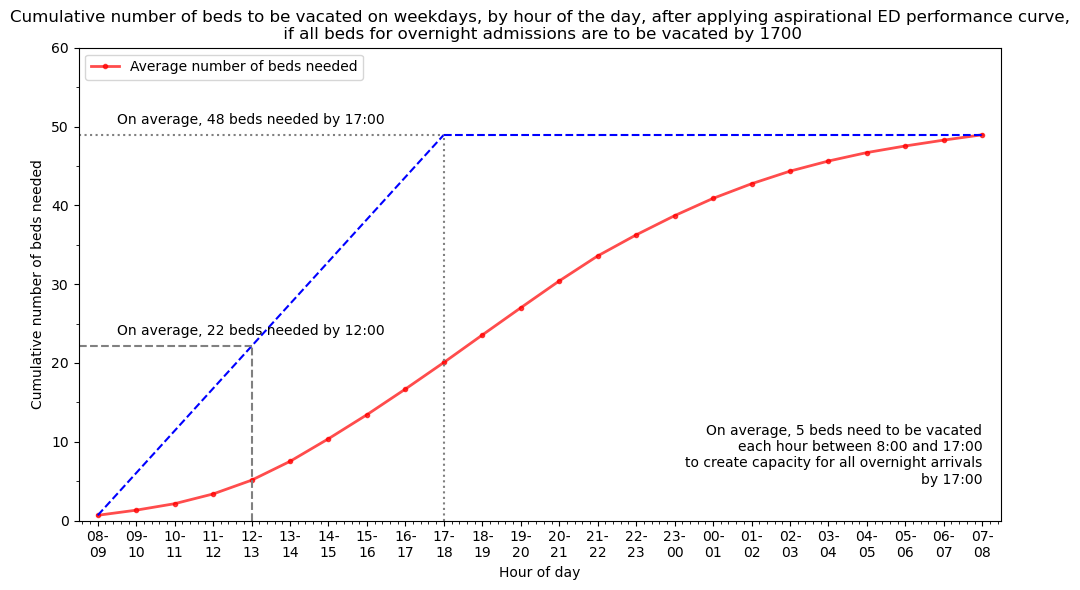

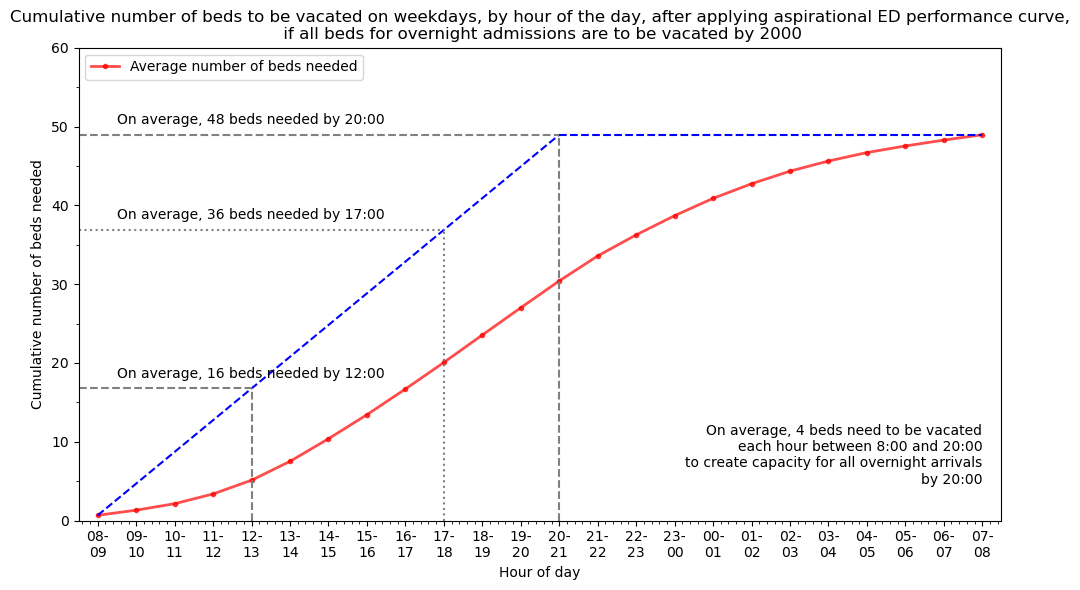

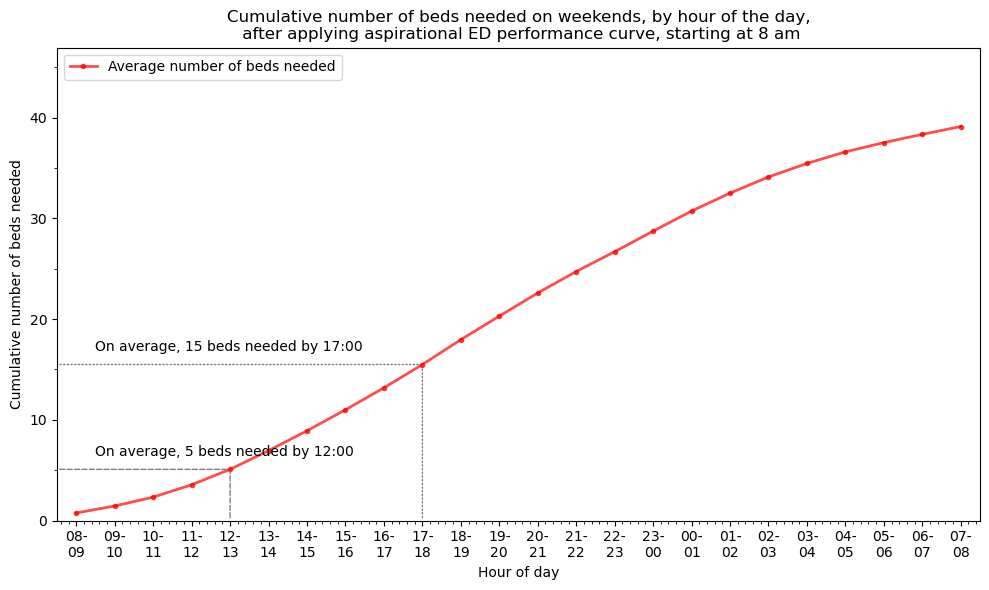

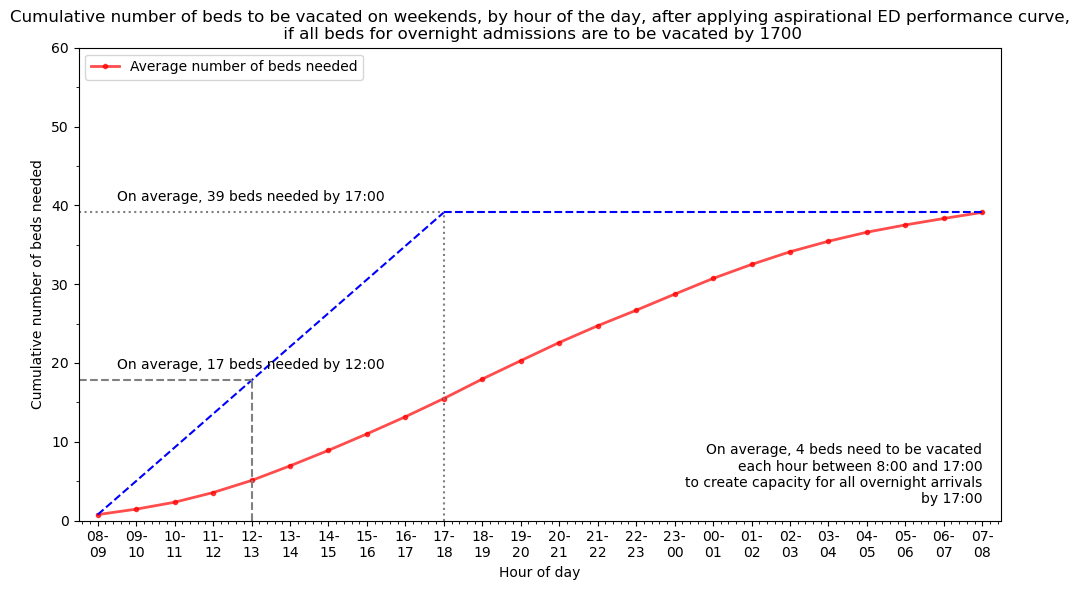

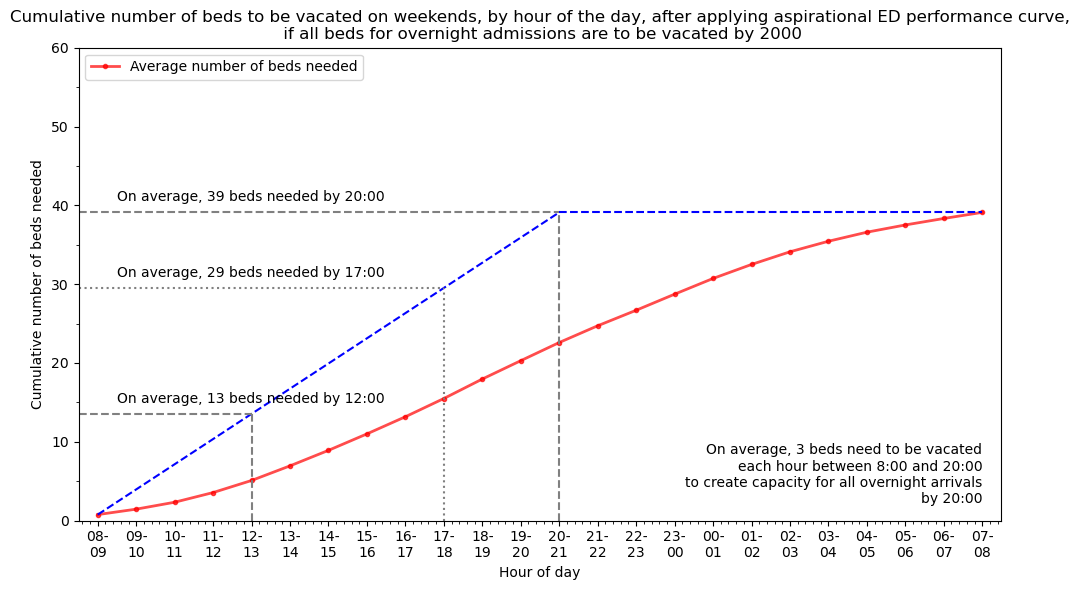

In [69]:
def plot_average_beds_needed_using_aspirational_curve(scenarios):
    """
    Generate bed occupancy plots for both weekday and weekend data, after applying aspirational curve.
    """
    
    for key, scenario in scenarios.items():
        # First plot: 4-hour admission delay
        title = f'Cumulative number of beds needed on {scenario["label"]}, by hour of the day,\n after applying aspirational ED performance curve, starting at 8 am'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            media_file_path=scenario["file_path"],
            file_prefix='6_',
            num_days=scenario["num_days"]
        )
        
        # Second plot: 17:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {17}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 17),
            media_file_path=scenario["file_path"],
            file_prefix='7_',
            set_y_lim=60,
            num_days=scenario["num_days"]
        )
        
        # Second plot: 20:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {20}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 20),
            media_file_path=scenario["file_path"],
            file_prefix='7_',
            set_y_lim=60,
            hour_lines=[12,17,20],
            num_days=scenario["num_days"]
        )

plot_average_beds_needed_using_aspirational_curve(scenarios)

## Cumulative plot with probabilities

Up to now, we have worked with the average number of beds needed. If this number of beds were ready, the hospital would be equipped to hit its ED targets on a day with average arrival rates, but not on a day that exceeds the average. On such days, the performance against 4-hour targets would deteriorate. 

Here we allow for the idea that a hospital might set an aspiration to hit its ED targets on (say) 90% of days.  

The code below shows how to plot a chart that explores how the number of beds needed by a given hour of the day will change if 4-hour targets are to be met on 90% of days. The red line is the same as above (the  beds that need to be vacated to meet average demand), and the blue dotted line shows the number of empty beds would need to be to ensure that enough capacity is available on 90% of days. 

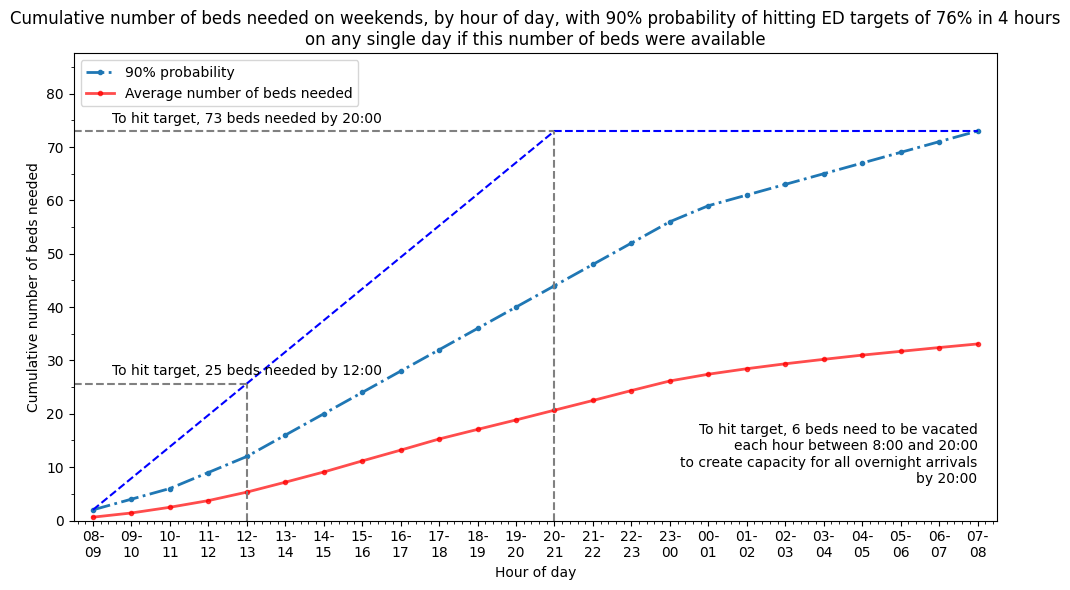

In [21]:


# plot showing just 90% centile for weekends
title = f'Cumulative number of beds needed on weekends, by hour of day, with 90% probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekends,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=(start_of_influencable_window, 20),
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12,20],
    annotation_prefix='To hit target',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[ 0.9],
    markers=['o'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekends,
    num_days=num_weekends


)

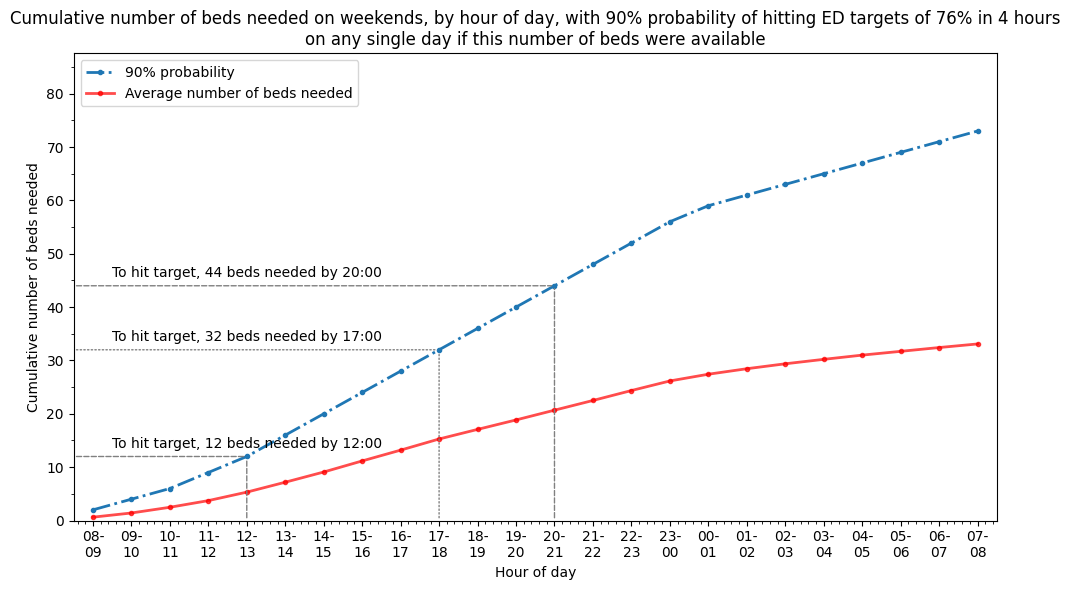

In [26]:


# plot showing just 90% centile for weekends, with influenceable window
title = f'Cumulative number of beds needed on weekends, by hour of day, with 90% probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekends,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12,17,20],
    annotation_prefix='To hit target',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[ 0.9],
    markers=['o'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekends,
    num_days=num_weekends


)

For completeness, we show here how you could plot any number of centiles of probability. 

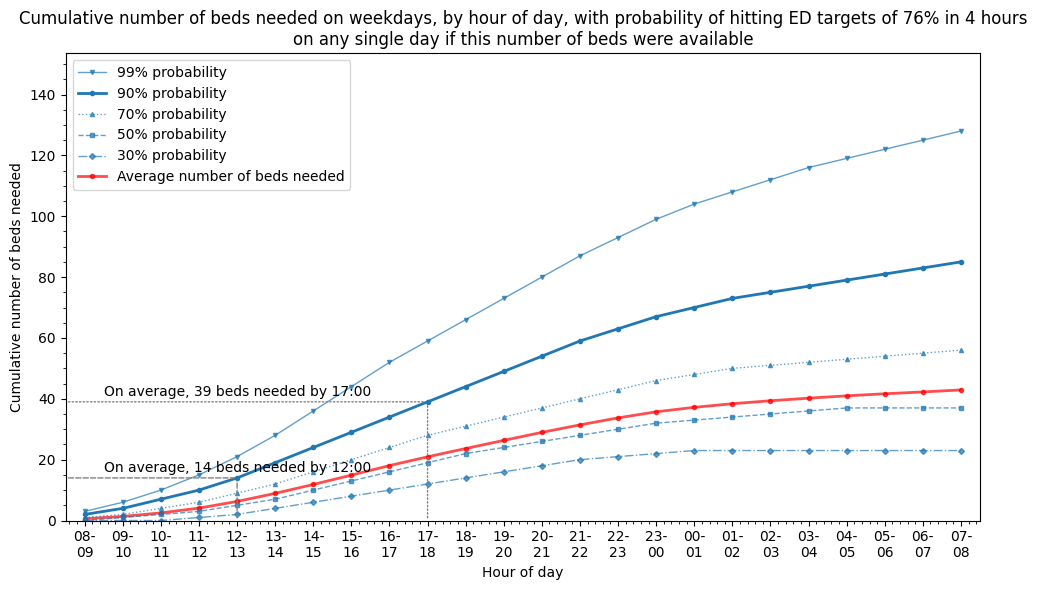

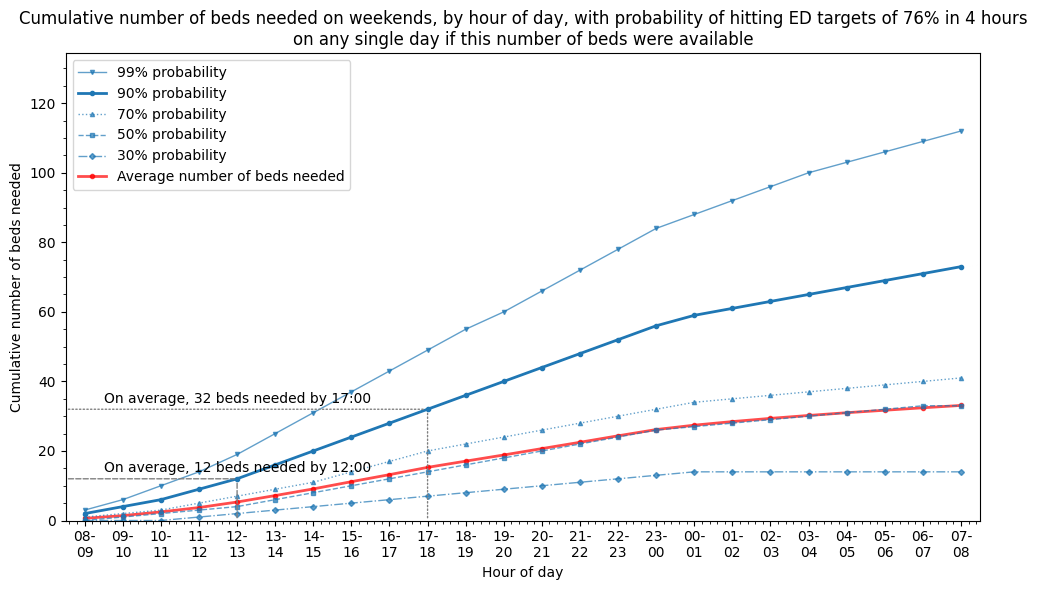

In [94]:
title = f'Cumulative number of beds needed on weekdays, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekdays,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12, 17],
    line_styles={12: '--', 17: ':'},
    annotation_prefix='On average',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
    markers=['D', 's', '^', 'o', 'v'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekdays,
    num_days=num_weekdays

)

title = f'Cumulative number of beds needed on weekends, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekends,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12, 17],
    line_styles={12: '--', 17: ':'},
    annotation_prefix='On average',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
    markers=['D', 's', '^', 'o', 'v'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekends,
    num_days=num_weekends


)

## Plot by specialty

Below we show a breakdown by specialty

In [ ]:
inpatient_arrivals = inpatient_arrivals.rename(columns = {'DestinationPatientService' : 'specialty'})
weekdays = weekdays.rename(columns = {'DestinationPatientService' : 'specialty'})
weekends = weekends.rename(columns = {'DestinationPatientService' : 'specialty'})

In [39]:
inpatient_arrivals.columns

Index(['HospitalProviderSpellNumber', 'AdmissionType', 'is_child', 'Sex',
       'arrival_day', 'IsED_Flag', 'IsSDEC_Flag', 'IsEDAndSDEC_Flag',
       'SDEC_In_Datetime', 'Ward_In_Datetime', 'SiteCode', 'WardCode',
       'specialty', 'RequestedInstant', 'SourceWard', 'DestWard'],
      dtype='object')

In [31]:
specialties = ['Acute Medicine', 'Accident & Emergency', 
       'Paediatric - General', 'Oncology - Acute Oncology Service',
       'ENT - General', 'General Surgery - General',
       'Gynaecology - Oncology', 'Neurology - General Stroke',
       'Infectious Diseases', 'Oncology - Gynae - Medical']

In [ ]:
scenario['data']

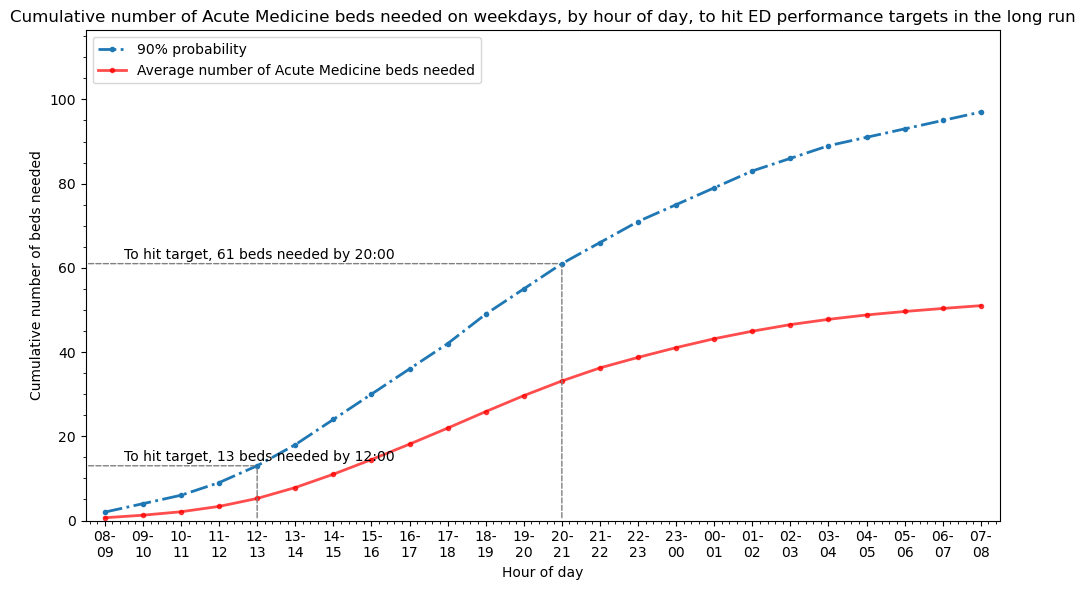

Skipping plot with intended title of Cumulative number of Accident & Emergency beds needed on weekdays, by hour of day, to hit ED performance targets in the long run
Insufficient volume (0.1 arrivals per day)


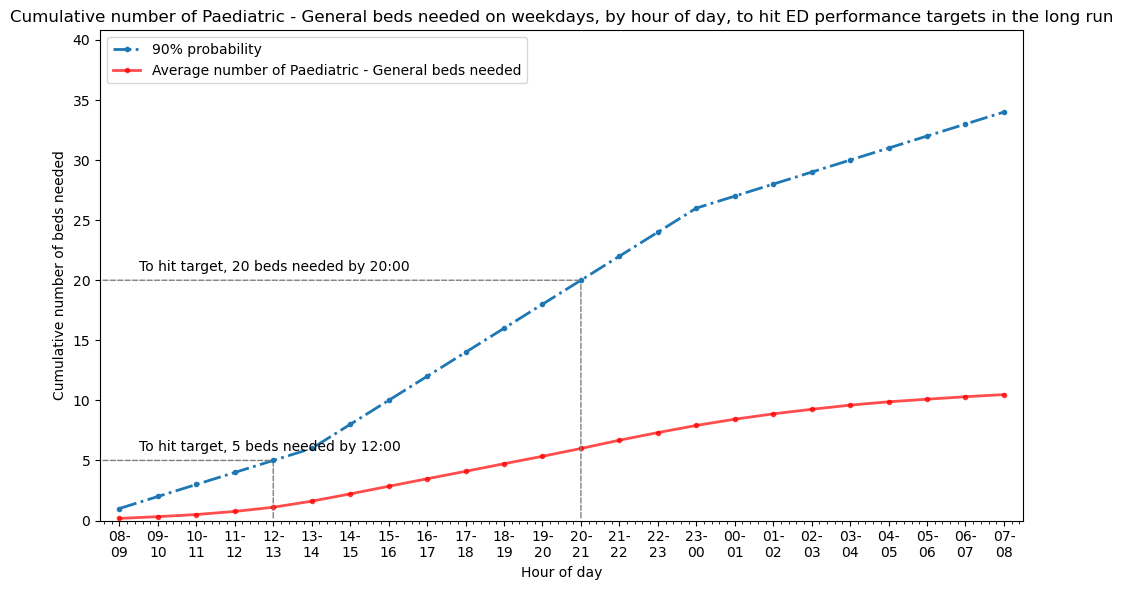

Skipping plot with intended title of Cumulative number of Oncology - Acute Oncology Service beds needed on weekdays, by hour of day, to hit ED performance targets in the long run
Insufficient volume (3.3 arrivals per day)
Skipping plot with intended title of Cumulative number of ENT - General beds needed on weekdays, by hour of day, to hit ED performance targets in the long run
Insufficient volume (2.5 arrivals per day)


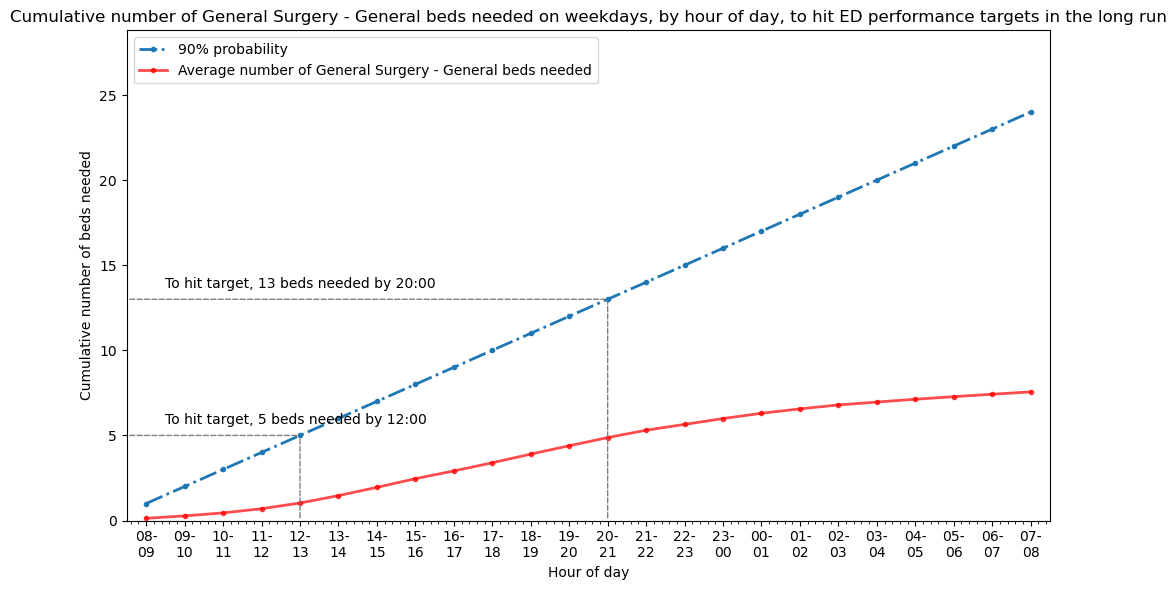

Skipping plot with intended title of Cumulative number of Gynaecology - Oncology beds needed on weekdays, by hour of day, to hit ED performance targets in the long run
Insufficient volume (0.0 arrivals per day)
Skipping plot with intended title of Cumulative number of Neurology - General Stroke beds needed on weekdays, by hour of day, to hit ED performance targets in the long run
Insufficient volume (1.4 arrivals per day)
Skipping plot with intended title of Cumulative number of Infectious Diseases beds needed on weekdays, by hour of day, to hit ED performance targets in the long run
Insufficient volume (2.8 arrivals per day)
Skipping plot with intended title of Cumulative number of Oncology - Gynae - Medical beds needed on weekdays, by hour of day, to hit ED performance targets in the long run
Insufficient volume (0.5 arrivals per day)


In [75]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates

def plot_by_specialty(scenario, specialties, specialty_name = 'specialty'):

    for _spec in specialties:
        inpatient_arrivals = scenario['data']
        inpatient_arrivals_spec = inpatient_arrivals[(~inpatient_arrivals[specialty_name].isnull()) & (inpatient_arrivals[specialty_name] == _spec)]
        __spec = _spec.replace('/', '_')
        
        title = f'Cumulative number of {__spec} beds needed on {scenario["label"]}, by hour of day, to hit ED performance targets in the long run'
    
        plot_cumulative_arrival_rates(
        inpatient_arrivals_spec,
            title,
            curve_params=(x1, y1, x2, y2),
            lagged_by=None,
            time_interval=60,
            start_plot_index=8,
            draw_window=None,
            x_margin=0.5,
            file_prefix='A_',
            set_y_lim=None,
            hour_lines=[12, 20],
            annotation_prefix='To hit target',
            line_colour='red',
            plot_centiles=True,
            highlight_centile=0.9,
            centiles=[0.9],
            markers=['o'],
            line_styles_centiles=['-.', '--', ':', '-', '-'],
            bed_type_spec=__spec, 
            text_y_offset=0.5,
            media_file_path=media_file_path_weekends,
            num_days=num_weekends,
            min_threshold=5

        )
plot_by_specialty(scenarios['weekdays'], specialties )



## 

## 

## 

## 

## Conclusion

The charts above have used in presentations with UCLH's patient flow improvement group, as part of a wider project on Emergency Patient Pathways. They help to focus attention on a very intractable problem. Hospitals are full, most of the time. Beds are vacated at certain times of day, typically afternoons and early evening. People show up at the ED/SDEC all through the day, not just at times that suit the way the hospital works. This makes it very difficult to hit ED targets when hospitals are full, unless proactive steps are taken. 

Note that all the charts have been created using only a very simple set of inputs